###  Use Recurrent Neural Network for Multivraite Time Series 
The absolute values of *Open/Higth/Low/Close* used for the forecasting after being scaled.

In [36]:
#import all libraries
import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image
import ml_metrics as metric
import forecasting_metrics as fmetric
#from tensorflow.python.framework import ops
tf.reset_default_graph()

In [37]:
# import dataset 
dataset = pd.read_csv('stock_market_data-AAL.csv')
df_stock = dataset.copy()
df_stock = df_stock.dropna().sort_values(by=['Date'])
print(df_stock[:10])
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]
print(df_stock[:10])
print('Dataset shape = ',df_stock.shape)

      index        Date    Low   High  Close   Open
3392      0  2005-09-27  19.10  21.40  19.30  21.05
3391      1  2005-09-28  19.20  20.53  20.50  19.30
3390      2  2005-09-29  20.10  20.58  20.21  20.40
3389      3  2005-09-30  20.18  21.05  21.01  20.26
3388      4  2005-10-03  20.90  21.75  21.50  20.90
3387      5  2005-10-04  21.44  22.50  22.16  21.44
3386      6  2005-10-05  21.75  22.31  22.20  22.10
3385      7  2005-10-06  22.40  23.00  22.58  22.60
3384      8  2005-10-07  21.80  22.60  22.15  22.25
3383      9  2005-10-10  22.10  22.29  22.21  22.28
       Open   High    Low  Close
3392  21.05  21.40  19.10  19.30
3391  19.30  20.53  19.20  20.50
3390  20.40  20.58  20.10  20.21
3389  20.26  21.05  20.18  21.01
3388  20.90  21.75  20.90  21.50
3387  21.44  22.50  21.44  22.16
3386  22.10  22.31  21.75  22.20
3385  22.60  23.00  22.40  22.58
3384  22.25  22.60  21.80  22.15
3383  22.28  22.29  22.10  22.21
Dataset shape =  (3393, 4)


### Standardizing the dataset
The scaling is performed using sklearn’s `MinMaxScaler`.

In [46]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)
print(df_stock_norm[:10])

          Open      High       Low     Close
3392  0.315980  0.316297  0.291495  0.286648
3391  0.287239  0.302090  0.293146  0.306259
3390  0.305305  0.302907  0.308010  0.301520
3389  0.303005  0.310581  0.309331  0.314594
3388  0.313516  0.322012  0.321222  0.322602
3387  0.322385  0.334259  0.330140  0.333388
3386  0.333224  0.331156  0.335260  0.334042
3385  0.341435  0.342423  0.345995  0.340252
3384  0.335687  0.335892  0.336086  0.333224
3383  0.336180  0.330830  0.341040  0.334205


### Splitting the dataset into Training and Testing: building X & Y
The whole dataset is split into train, valid and test data. 
The result is: `x_train`, `y_train`, `x_valid`, `y_valid`, `x_test` and `y_test`. This is a crucial part.

In [47]:
# Splitting the dataset into Train, Valid & test data 
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20
def load_data(stock, seq_len):
    data_raw = stock.values
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2699, 19, 4)
y_train.shape =  (2699, 4)
x_valid.shape =  (337, 19, 4)
y_valid.shape =  (337, 4)
x_test.shape =  (337, 19, 4)
y_test.shape =  (337, 4)


### Building the Model

#### Parameters, Placeholders & Variables
We will first fix the Parameters, Placeholders & Variables to building any model. The Artificial Neural Network starts with placeholders. Two placeholders is neede in order to fit the model: X contains the network’s inputs (features of the stock (OHLC) at time _T = t_ ) and Y the network’s output: _Price of the stock at T+1_ . The shape of the placeholders corresponds to [None, n_inputs] with [None] meaning that the inputs are a 2-dimensional matrix and the outputs are a 1-dimensional vector. The crucial part is to properly define the input and output dimensions so the neural net in order to design it properly. 
The variable batch size is 10. It controls the number of observations per training batch. The training is stopped when epoch reaches 100.

In [56]:

## Building the Model
# parameters & Placeholders 
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 64 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 10
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])


### Designing the network architecture
The function `get_next_batch` runs the next batch for any model . Then we will write the layers for each model separately.

In [58]:
# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

Let's run the model using GRU cell: https://en.wikipedia.org/wiki/Gated_recurrent_unit

In [59]:
#GRU 
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
          for layer in range(n_layers)] 
                                                                  
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

### Cost function function to optimize the model

The cost function is used to generate a measure of deviation between the network’s predictions and the actual observed training targets. The `MSE` computes the average squared deviation between predictions and targets.

In [60]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

### Optimizer
The optimizer takes care of the necessary computations that are used to adapt the network’s weight and bias variables during training. Those computations invoke the _calculation of gradients_ that indicate the direction in which the _weights and biases have to be changed_ during training in order to minimize the network’s cost function. The development of stable and speedy optimizers is a *major field in neural network and deep learning research*.

In [61]:
#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In this model we use Adam (Adaptive Moment Estimation) Optimizer, which is an extension of the stochastic gradient descent, is one of the default optimizers in deep learning development.

### Fitting the neural network model & prediction


The training of the network stops once the maximum number of epochs is reached or another stopping criterion defined by the user applies. The training stops when epoch reaches 100.

In [62]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) # get the MSE of train
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) # get the MSE of validation
            print('%.2f epochs: RMSE train/valid = %.6f/%.6f'%( # print RMSE to compare to ARIMA
                iteration*batch_size/train_set_size, math.sqrt(mse_train), math.sqrt(mse_valid)))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})


0.00 epochs: RMSE train/valid = 0.487622/0.780604
5.00 epochs: RMSE train/valid = 0.018719/0.022703
10.00 epochs: RMSE train/valid = 0.013004/0.013554
14.99 epochs: RMSE train/valid = 0.012757/0.015028
19.99 epochs: RMSE train/valid = 0.011127/0.012275
24.99 epochs: RMSE train/valid = 0.011246/0.012548
29.99 epochs: RMSE train/valid = 0.010858/0.011753
34.99 epochs: RMSE train/valid = 0.016264/0.022046
39.99 epochs: RMSE train/valid = 0.010748/0.011374
44.98 epochs: RMSE train/valid = 0.010480/0.011718
49.98 epochs: RMSE train/valid = 0.012252/0.015440
54.98 epochs: RMSE train/valid = 0.010411/0.011213
59.98 epochs: RMSE train/valid = 0.010583/0.011508
64.98 epochs: RMSE train/valid = 0.010860/0.011061
69.97 epochs: RMSE train/valid = 0.011783/0.012862
74.97 epochs: RMSE train/valid = 0.010892/0.012171
79.97 epochs: RMSE train/valid = 0.010369/0.010974
84.97 epochs: RMSE train/valid = 0.010585/0.011419
89.97 epochs: RMSE train/valid = 0.011733/0.013727
94.96 epochs: RMSE train/valid = 

In [63]:
#checking prediction output nos 
print(y_test_pred.shape)

(337, 4)


Now we have predicted the scaled stock prices and saved as y_test_pred. We can compare these predicted stock prices with our target scaled stock prices which is y_test.

Let’s compare between our target and prediction.

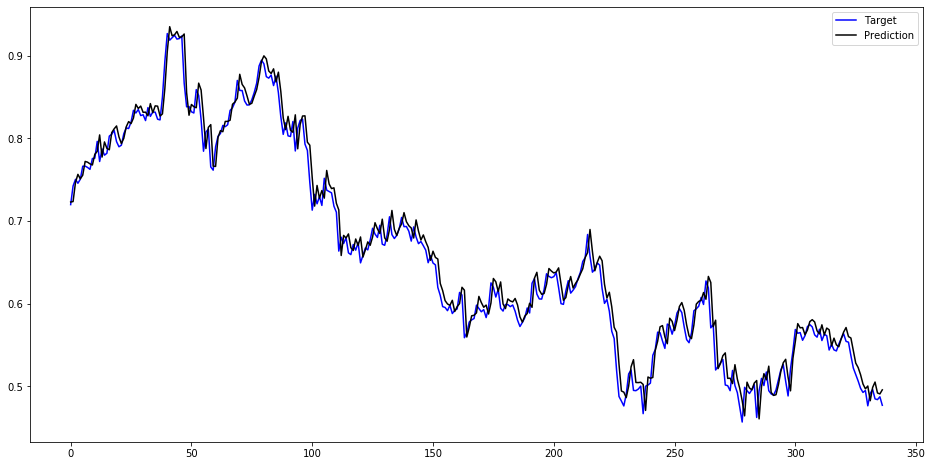

{'MAE': 0.01304961807455235,
 'MAPE': 2.0792257024726557,
 'MASE': inf,
 'ME': -0.0065302705519578,
 'MPE': -1.083089080684156,
 'RMSE': 0.0172993085884861}


/Users/iostaptchenko/projects/secret/wsu/ie7860/Recurrent Neural Network Assignment/forecasting_metrics.py:171: RuntimeWarning: divide by zero encountered in double_scalars
  return mae(actual, predicted) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))


In [64]:
# ploting the graph
comp = pd.DataFrame({'test':y_test[:,3],'pred':y_test_pred[:,3]})
plt.figure(figsize=(16,8))
plt.plot(comp['test'], color='blue', label='Target')
plt.plot(comp['pred'], color='black', label='Prediction')
plt.legend()
plt.show()
# Print errors
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

errors = {
'ME':  fmetric.me(actual=comp['test'], predicted=comp['pred']),
'RMSE': fmetric.rmse(actual=comp['test'], predicted=comp['pred']),
'MAE':  fmetric.mae(actual=comp['test'], predicted=comp['pred']),
'MPE':  100*fmetric.mpe(actual=comp['test'], predicted=comp['pred']),
'MAPE': mape(comp['test'], comp['pred']),
'MASE': fmetric.mase(actual=comp['test'], predicted=comp['pred']),
}
from pprint import pprint
pprint(errors)


The picture show the predicted values closely follow the target. The forecasting errors are printed to be compared with ARIMA.


## Conclusions

The error metrics compared in the table bellow:


| Forecasting method |            ME |       RMSE |        MAE |       MPE |     MAPE | MASE      |
|--------------------|---------------|------------|------------|-----------|----------|-----------|
| ARIMA              |  0.0002783467 | 0.01844228 | 0.01419282 |  97.74705 | 97.74705 | 0.3484213 |
| RNN                | -0.0065302706 | 0.01729931 | 0.01304962 |  -1.08309 |  2.07923 | Inf       |


While `RMSE`, `MAE` are at the same scale . Where `RNN` is superriour is in `MPE` and `MAPE`. The ARIMA error values for `MPE` and `MAPE` on this dataset renders it useles for predictions.
The RNN  has an advantage in multivariate Time Series analisys: a few variables had been fed to network simultaniously and contributed to prediction.
The 'R's ARIMA fit was done in signigicantly less time then training of RNN, that are more computationly intensive on the training phase.

## Literature

* https://github.com/borodark/wsu/blob/master/methods/casestudy/toc.md
* Robert H. Shumway David S. Stoffer, Time Series Analysis and Its Applications With R Examples, Fourth Edition
* Ratnadip Adhikari R. K. Agrawal, An Introductory Study on Time Series Modeling and Forecasting
* Analysis of Financial Time Series, Financial Econometrics, RUEY S. TSAY University of Chicago
* Tsay, Ruey S., An introduction to analysis of financial data with R/Ruey S. Tsay. p. cm. Includes index. ISBN 978-0-470-89081-3
* An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling, Shaojie Bai, J. Zico Kolter, Vladlen Koltun
* Temporal Convolutional Networks: A Unified Approach to Action Segmentation by Colin Lea Rene ́ Vidal Austin Reiter Gregory D. Hager, Johns Hopkins University
* A comparison of performance of several artificial intelligence methods for forecasting monthly discharge time series by Wen-Chuan Wang, Kwok-Wing Chau, Chun-Tian Cheng, Lin Qiu, Journal of Hydrology, Vol. 374, No. 3-4, 2009, pp 294–306
* https://people.duke.edu/~rnau/411diff.htm